In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [12]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt

import os
import numpy as np
from skimage import io, transform


In [13]:
train_dir = "/kaggle/input/mlds-assignment-2/train/train/"
test_dir = "/kaggle/input/mlds-assignment-2/test/test/"

Below  function is to see the images formed for debugging purpose

In [90]:
def show_img(txt, img):
#         print(txt)
#         plt.imshow(img)
#         plt.axis('off')  # Hide axis
#         plt.show()
        return

In [15]:
def load_and_resize_images(directory,target_size, flag):
    images = [] # to get the images and masks from
    masks=[]
#     itr=0 # while debugging to check few examples
    for filename in os.listdir(directory):
#         if itr==10:
#             break
#         itr+=1
        img = io.imread(os.path.join(directory, filename))
#         show_img("Real input::", img)
        if flag: # for test set, no masks
            resized_img = transform.resize(img[:,:,:3], target_size, anti_aliasing=True)
#             show_img("Test img reduced:", resized_img)
            images.append(resized_img)
            masks.append(None)
            
            
        if not flag:       #for train dataset
            j=int(img.shape[1]/2) # splitting the image into 2 halves
            train_img = img[:,:j,:3]
            mask = img[:,j:,:]

#             show_img("cropped real input::", train_img)
#             show_img("mask cropped real input::", mask)

            resized_img = transform.resize(train_img, target_size, anti_aliasing=True)
#             show_img("Resized input::",resized_img )
            resized_mask = transform.resize(mask, target_size, anti_aliasing=True)
#             show_img("Resized mask::", resized_mask)
#             label = train_csv[train_csv['id']==filename]['binary_pred'].values[0]
      
        
            images.append(resized_img)
            masks.append(resized_mask)

            
    return np.array(images), np.array(masks) #getting resized images and respective masks for PCA


Getting the image and respective masks for train. Reducing image size for test:

In [16]:
# Example usage
target_size = (32,32)

train_images, masks = load_and_resize_images(train_dir, target_size,  False)
test_images, _ = load_and_resize_images(test_dir, target_size, True)

# train_dataframe= load_and_resize_images(train_dir, target_size,  False)
# test_dataframe= load_and_resize_images(test_dir, target_size, True)

Utility Functions to find PCA:

In [17]:
def center_data(X):
#     print(X.shape)
    mean_X = np.mean(X, axis=0)
    centered_X = X - mean_X
    return centered_X, mean_X

# Function to compute covariance matrix
def compute_covariance_matrix(X):
    num_samples = X.shape[0]
#     print("Num sapmls::", num_samples)
    covariance_matrix = np.dot(X.T, X) / (num_samples-1)
    return covariance_matrix

# Function to perform eigen decomposition
def eigen_decomposition(covariance_matrix):
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    sorted_indices = np.argsort(eigenvalues)[::-1]  # Sort eigenvalues in descending order
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    return eigenvalues, eigenvectors
def svd_decomposition(covariance_matrix):
    U, S, Vt = np.linalg.svd(covariance_matrix, full_matrices=False, )
    return S, U

def project_onto_pc(X, eigenvectors, n_components):
    return np.dot(X, eigenvectors[:, :n_components])

# Function to reconstruct data from projected space
def reconstruct_from_pc(X_proj, eigenvectors, mean_X):
    return np.dot(X_proj, eigenvectors[:, :X_proj.shape[1]].T) + mean_X

PCA from scratch involves decomposition by SVD and reconstructing the matrix by considering only the important eigen values. No.of components is decided by checking the plot of eigen values. [Approximately not considering values <0.5]

eigen values::  [106.13067905   9.67652704   7.90951426   6.43544277   5.8179941
   4.59014453   4.04613263   3.40833539   3.31116733   2.92380014
   2.27505138   2.17956218   2.00677157   1.92013852   1.65387098
   1.48570915   1.37035639   1.34762985   1.12879894   1.0702246
   1.02654559   0.98420223   0.94153833   0.8954787    0.87710639
   0.83681204   0.81203688   0.79701889   0.71479553   0.69408733
   0.68618627   0.66478936   0.64067799   0.61074613   0.58459843
   0.57046886   0.5450542    0.5278833    0.49478196   0.49001397
   0.48589798   0.47453952   0.459822     0.43206054   0.4281327
   0.41211212   0.40869069   0.38993821   0.37452605   0.36453327]


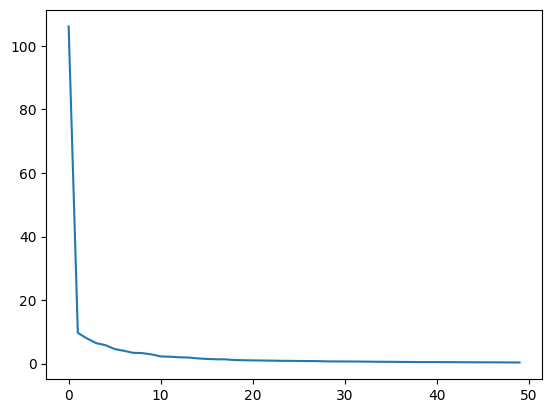

In [18]:
def apply_pca_without_library(images, n_components):
    num_samples = images.shape[0]
#     print("No.of samples::::", num_samples)
    flattened_images = images.reshape(num_samples, -1)

    centered_images, mean_image = center_data(flattened_images)

    covariance_matrix = compute_covariance_matrix(centered_images)

    # Perform eigen decomposition
#     eigenvalues, eigenvectors = eigen_decomposition(covariance_matrix)
    eigenvalues, eigenvectors = svd_decomposition(covariance_matrix)
    print("eigen values:: ", eigenvalues[:n_components])
    
    plt.plot(range(n_components), eigenvalues[:n_components])
    plt.show()
    # Project data onto principal components
    projected_images = project_onto_pc(centered_images, eigenvectors, n_components)

    # Reconstruct images from projected space
    reconstructed_images = reconstruct_from_pc(projected_images, eigenvectors, mean_image)

    return projected_images, reconstructed_images

n_components = 50  # logs
# train_images = np.array(train_dataframe['image'])
# train_images = train_dataframe

# Apply PCA for image compression on training images
train_compressed, reconstructed_train_images = apply_pca_without_library(train_images, n_components)

# Apply PCA for image compression on test images
# test_compressed, reconstructed_test_images = apply_pca_without_library(test_images_resized, n_components)

eigen values::  [112.18539954  10.33816497   8.31398827   6.03272437   5.24184565
   4.81512451   4.15917221   4.00438181   3.79449325   3.14774683
   2.51995033   2.16936076   2.02290352   2.01580418   1.73366358
   1.63087958   1.49828019   1.35055526   1.26553848   1.20504562
   1.14743376   1.04684669   1.02015243   1.00309718   0.97024462
   0.90149418   0.88069881   0.84097497   0.80907342   0.78134527
   0.75883391   0.74134771   0.70787844   0.683783     0.64193652
   0.61390118   0.61245344   0.57189278   0.5617672    0.54704807
   0.54158099   0.52319983   0.49999332   0.4804857    0.47081543
   0.45057481   0.43944533   0.4290942    0.42013557   0.40950636]


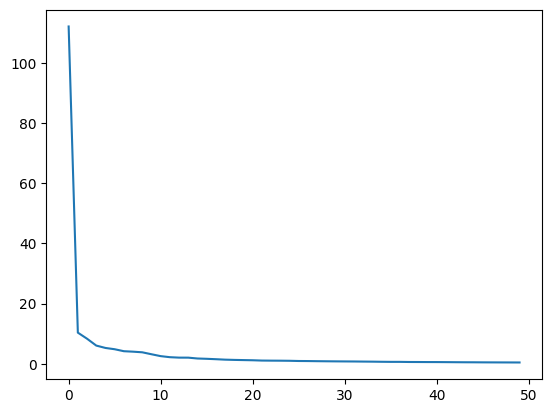

In [19]:
# Apply PCA for image compression on test images
test_compressed, reconstructed_test_images = apply_pca_without_library(test_images, n_components)

In [20]:
print("Shape of compressed training images:", train_compressed.shape)
print("Shape of reconstructed training images:", reconstructed_train_images.shape)
print("Shape of compressed test images:", test_compressed.shape)
print("Shape of reconstructed test images:", reconstructed_test_images.shape)

Shape of compressed training images: (919, 50)
Shape of reconstructed training images: (919, 3072)
Shape of compressed test images: (394, 50)
Shape of reconstructed test images: (394, 3072)


Checking plots for 2 most varied directions. Also checking in 3D for 3 components.

In [21]:
import matplotlib.pyplot as plt

# Plotting PCA
def plot_pca(data, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(data[:, 0], data[:, 1], alpha=0.5)
    plt.title(title)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.grid(True)
    plt.show()

# Example usage
# Plot PCA for compressed training images
plot_pca(train_compressed, "PCA Plot for Compressed Training Images")
plot_pca(test_compressed, "PCA Plot for Compressed Testing Images")

clearly we can see 2 clusters for both train and test dataset. One of them is healthy and other unhealthy. PCA on test dataset is applied above. Checking the same in 3D:

In [22]:
!pip install plotly

In [23]:
import plotly.graph_objs as go

# Plotting PCA with Plotly
def plot_pca_3d_interactive(data, title):
    fig = go.Figure(data=[go.Scatter3d(
        x=data[:, 0],
        y=data[:, 1],
        z=data[:, 2],
        mode='markers',
        marker=dict(
            size=5,
            opacity=0.5
        )
    )])

    fig.update_layout(title=title, scene=dict(
        xaxis_title='Principal Component 1',
        yaxis_title='Principal Component 2',
        zaxis_title='Principal Component 3'
    ))

    fig.show()

# Example usage
# Assuming 'train_compressed' contains the PCA-projected data with 3 principal components
plot_pca_3d_interactive(train_compressed, "PCA Plot for Compressed Training Images (3D)")


Thus the High Dimensional data can be viewd in 3D also without much loss in its energy/information.

# Classification 

Not using the PCA data to continue below. One can also use the PCA data to create dataframes.

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


Making the DF with filename, image value, label and mask

In [25]:
def make_DF(directory,target_size, flag):
    data = {'filename': [], 'image': [], 'label': [], 'mask': [] }
    images = []
    masks=[]
    itr=0
   
    for filename in os.listdir(directory):
#         if itr==10:
#             break
#         itr+=1
        data['filename'].append(filename)

        img = io.imread(os.path.join(directory, filename))
#         show_img("Real input::", img)
        if flag:
            resized_img = transform.resize(img[:,:,:3], target_size, anti_aliasing=True)
#             show_img("Test img reduced:", resized_img)
#             images.append(resized_img)
            data['image'].append(resized_img)
#     following to be predicted for TEST data
            data['label'].append(None)
            data['mask'].append(None)
            
        if not flag:       
            train_csv = pd.read_csv("/kaggle/input/mlds-assignment-2/train.csv")
            j=int(img.shape[1]/2)
    #         print(img.shape[1], j, img)
            train_img = img[:,:j,:3]
            mask = img[:,j:,1]
    #         print("%%%%%%%%%%")
    #         print("Resized::", resized_img.shape, resized_img)

#             show_img("cropped real input::", train_img)

#             show_img("mask cropped real input::", mask)

            resized_img = transform.resize(train_img, target_size, anti_aliasing=True)
#             show_img("Resized input::",resized_img )

            resized_mask = transform.resize(mask, target_size, anti_aliasing=True)
#             show_img("Resized mask::", resized_mask)
#             print(train_csv[train_csv['id']==filename]['binary_pred'])
            label = train_csv[train_csv['id']==filename]['binary_pred'].values[0]
#             print("label::", label)


#             images.append(resized_img)
            data['image'].append(resized_img)
            data['mask'].append(resized_mask)
            data['label'].append(label)
            

#         break
#     print("===========")
#     return np.array(images), np.array(masks)
    return pd.DataFrame(data)

In [26]:
target_size = (32,32)

train_dataframe= make_DF(train_dir, target_size,  False)
test_dataframe= make_DF(test_dir, target_size, True)

In [27]:
(train_dataframe)

filename                                              image  label  \
0    Img_687.png  [[[0.9842883602927721, 0.9885390737429949, 0.9...      0   
1    Img_421.png  [[[0.33452868367558736, 0.5948800019780677, 0....      0   
2    Img_837.png  [[[0.14760689438714006, 0.23537167207638776, 0...      0   
3    Img_834.png  [[[0.44637789753739543, 0.7327032872757568, 0....      0   
4    Img_782.png  [[[0.21875550955878442, 0.22219866167681723, 0...      0   
..           ...                                                ...    ...   
914  Img_646.png  [[[0.1814002046950509, 0.3429137220819938, 0.2...      0   
915  Img_772.png  [[[0.13315387218223174, 0.1682499175337756, 0....      1   
916   Img_52.png  [[[0.2223322636408516, 0.362027430167015, 0.15...      0   
917  Img_279.png  [[[0.025330165483870314, 0.03623996096512631, ...      1   
918  Img_610.png  [[[0.09030538145155691, 0.11542513053775408, 0...      1   

                                                  mask  
0    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
1    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
2    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
3    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
4    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
..                                                 ...  
914  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
915  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
916  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
917  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
918  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  

[919 rows x 4 columns]

In [28]:
(test_dataframe)

filename                                              image label  \
0    Img_1157.png  [[[0.984907027845223, 0.984907027845223, 0.984...  None   
1    Img_1005.png  [[[0.9997297624248267, 0.9997297624248267, 0.9...  None   
2     Img_960.png  [[[0.17174205741942206, 0.14970343178908516, 0...  None   
3    Img_1016.png  [[[0.3074304956265189, 0.25996459801810123, 0....  None   
4     Img_988.png  [[[0.9976079483499333, 0.9979472048778749, 0.9...  None   
..            ...                                                ...   ...   
389   Img_929.png  [[[0.07389840376350645, 0.1598230463852428, 0....  None   
390  Img_1153.png  [[[0.1781806626447953, 0.22406810389855036, 0....  None   
391  Img_1151.png  [[[0.30974398494020067, 0.2779916380664357, 0....  None   
392   Img_939.png  [[[0.36669088077756884, 0.3369692292951584, 0....  None   
393  Img_1253.png  [[[0.5591548949539219, 0.8229232349740117, 0.3...  None   

     mask  
0    None  
1    None  
2    None  
3    None  
4    None  
..    ...  
389  None  
390  None  
391  None  
392  None  
393  None  

[394 rows x 4 columns]

In [29]:
# train_dataframe['image'].describe()

In [30]:
def get_XY(df):
    X = np.array(df['image'].tolist()).reshape(len(df), -1)
    y = np.array(df['label'])
    return X, y

Using Random Forest Classifier from sklearn as RF is an ensemble of many Decision trees and thus provides better classification results as variance and bias is reduced.

In [31]:
X, y = get_XY(train_dataframe)
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=300, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predictions
y_pred = rf_classifier.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.7608695652173914
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.72      0.76        99
           1       0.71      0.81      0.76        85

    accuracy                           0.76       184
   macro avg       0.76      0.76      0.76       184
weighted avg       0.77      0.76      0.76       184

Confusion Matrix:
[[71 28]
 [16 69]]


Getting Accuracy of 76%.

In [32]:
X_testset, _= get_XY(test_dataframe)
y_testset = rf_classifier.predict(X_testset)

In [89]:
# y_testset

In [34]:
test_dataframe['label'] = y_testset

In [35]:
test_dataframe

filename                                              image  label  \
0    Img_1157.png  [[[0.984907027845223, 0.984907027845223, 0.984...      0   
1    Img_1005.png  [[[0.9997297624248267, 0.9997297624248267, 0.9...      0   
2     Img_960.png  [[[0.17174205741942206, 0.14970343178908516, 0...      0   
3    Img_1016.png  [[[0.3074304956265189, 0.25996459801810123, 0....      0   
4     Img_988.png  [[[0.9976079483499333, 0.9979472048778749, 0.9...      1   
..            ...                                                ...    ...   
389   Img_929.png  [[[0.07389840376350645, 0.1598230463852428, 0....      0   
390  Img_1153.png  [[[0.1781806626447953, 0.22406810389855036, 0....      0   
391  Img_1151.png  [[[0.30974398494020067, 0.2779916380664357, 0....      1   
392   Img_939.png  [[[0.36669088077756884, 0.3369692292951584, 0....      0   
393  Img_1253.png  [[[0.5591548949539219, 0.8229232349740117, 0.3...      1   

     mask  
0    None  
1    None  
2    None  
3    None  
4    None  
..    ...  
389  None  
390  None  
391  None  
392  None  
393  None  

[394 rows x 4 columns]

In [ ]:


# # Create a DataFrame with the required columns
# submission_df = pd.DataFrame({
#     'id': test_dataframe['filename'],
#     'binary_pred': y_testset,
# #     'segmentation_pred': ['Healthy' if label == 0 else [1] for label in y_testset]
#     'segmentation_pred': 'Healthy'

# })

# # Save the DataFrame to a CSV file
# # submission_df.to_csv('mlds_a2_submission.csv', index=False)

# Segmentation

@misc{Yakubovskiy:2019,
  Author = {Pavel Iakubovskii},
  Title = {Segmentation Models},
  Year = {2019},
  Publisher = {GitHub},
  Journal = {GitHub repository},
  Howpublished = {\url{https://github.com/qubvel/segmentation_models}}
} 

Using pre-trained model

In [40]:
!pip install segmentation-models


In [41]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm
# import segmentation_models as sm


2024-04-04 18:04:31.153047: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-04 18:04:31.153102: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-04 18:04:31.154702: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Segmentation Models: using `tf.keras` framework.


In [42]:
X = np.array(train_dataframe['image'])
# X

In [43]:
Y = np.array(train_dataframe['mask'])
# Y

In [68]:
BACKBONE = 'resnet34'  #'vgg19'
preprocess_input = sm.get_preprocessing(BACKBONE)

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

# define model
unet_model = sm.Unet(BACKBONE, encoder_weights='imagenet',  activation='sigmoid', encoder_freeze = True)
unet_model.compile(optimizer='adamw', loss='binary_crossentropy', metrics=['mse'])

In [69]:
# print(model.summary())
# Check data types and shapes
x_train = np.array(x_train.tolist(), dtype=np.float32)
y_train = np.array(y_train.tolist(), dtype=np.float32)

x_val = np.array(x_train.tolist(), dtype=np.float32)
y_val = np.array(y_train.tolist(), dtype=np.float32)

history=unet_model.fit(x_train, 
          y_train,
          batch_size=16 ,
          epochs=5, 
          verbose=1,
          validation_data=(x_val, y_val))


Epoch 1/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 65s 552ms/step - loss: 0.7214 - mse: 0.2354 - val_loss: 0.6755 - val_mse: 0.0788
Epoch 2/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.2780 - mse: 0.0611 - val_loss: 0.3456 - val_mse: 0.0798
Epoch 3/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.2211 - mse: 0.0475 - val_loss: 0.2664 - val_mse: 0.0582
Epoch 4/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.2078 - mse: 0.0471 - val_loss: 0.2670 - val_mse: 0.0578
Epoch 5/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1993 - mse: 0.0452 - val_loss: 0.3391 - val_mse: 0.0625


23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - loss: 0.3327 - mse: 0.0617
Accuracy:: [0.33928632736206055, 0.06253497302532196]


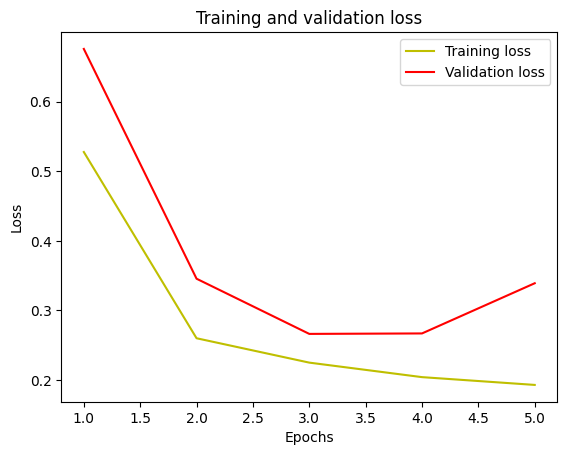

In [70]:





accuracy = unet_model.evaluate(x_val, y_val)
print("Accuracy::", accuracy)
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [71]:
# # unet_model.evaluate_generator(df_test)

# scores = unet_model.evaluate_generator(test_dataloader)

# print("Loss: {:.5}".format(scores[0]))
# for metric, value in zip(metrics, scores[1:]):
#     print("mean {}: {:.5}".format(metric.__name__, value))
    

In [72]:
def mask2rle(img):
    #https://www.kaggle.com/code/paulorzp/rle-functions-run-lenght-encode-decode
    #img: numpy array, 1 - mask, 0 - background
    #Returns run length as string formated
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(mask_rle, shape=(256,256)):
    #mask_rle: run-length as string formated (start length)
    #shape: (width,height) of array to return 
    #Returns numpy array, 1 - mask, 0 - background
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [73]:
# Preprocess test images using the same function
test_images = np.array(test_dataframe['image'])
test_images = preprocess_input(test_images)  # Apply preprocessing


In [74]:
test_images = np.array(test_images.tolist(), dtype=np.float32)
type(test_images)

numpy.ndarray

In [75]:
# test_images=np.expand_dims(test_images, axis=0)

In [87]:
# idx= 88
# show_img("reduced pic", test_images[idx])


In [77]:

# Make predictions on test images
predictions = unet_model.predict(test_images)



# ... (Process predictions based on your needs)

# Example: Threshold predictions (assuming binary segmentation)
threshold = 0.5  # Adjust threshold as needed
predicted_masks = (predictions > threshold).astype(np.uint8)  # Convert to binary masks

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 318ms/step


In [86]:
# predicted_masks[idx]

In [83]:
# show_img("reduced pic", test_images[idx])
# show_img("mask predicted", predictions[idx])

# show_img("mask predicted", predictions[55])



In [80]:
# predicted_masks[88]==predicted_masks[55]

In [81]:
rle_masks=[]
for mask in predicted_masks:
#     print(mask)
    rle_masks.append(mask2rle(mask))

# Add predicted masks to the test dataframe (optional)
test_dataframe['mask'] = rle_masks
# print("jjj::", rle_masks)

In [84]:
# rle_masks

In [85]:
# test_dataframe

In [59]:
test_dataframe['segmentation_pred'] = np.where(test_dataframe['label'] == 0, 'Healthy', test_dataframe['mask'])
test_dataframe

filename                                              image  label  \
0    Img_1157.png  [[[0.984907027845223, 0.984907027845223, 0.984...      0   
1    Img_1005.png  [[[0.9997297624248267, 0.9997297624248267, 0.9...      0   
2     Img_960.png  [[[0.17174205741942206, 0.14970343178908516, 0...      0   
3    Img_1016.png  [[[0.3074304956265189, 0.25996459801810123, 0....      0   
4     Img_988.png  [[[0.9976079483499333, 0.9979472048778749, 0.9...      1   
..            ...                                                ...    ...   
389   Img_929.png  [[[0.07389840376350645, 0.1598230463852428, 0....      0   
390  Img_1153.png  [[[0.1781806626447953, 0.22406810389855036, 0....      0   
391  Img_1151.png  [[[0.30974398494020067, 0.2779916380664357, 0....      1   
392   Img_939.png  [[[0.36669088077756884, 0.3369692292951584, 0....      0   
393  Img_1253.png  [[[0.5591548949539219, 0.8229232349740117, 0.3...      1   

    mask segmentation_pred  
0                  Healthy  
1                  Healthy  
2                  Healthy  
3                  Healthy  
4                           
..   ...               ...  
389                Healthy  
390                Healthy  
391                         
392                Healthy  
393                         

[394 rows x 5 columns]

In [60]:
# Create a DataFrame with the required columns
submission_df = pd.DataFrame({
    'id': test_dataframe['filename'],
    'binary_pred': y_testset,
    'segmentation_pred': test_dataframe['segmentation_pred']
#     'segmentation_pred': 'Healthy'

})

# Save the DataFrame to a CSV file
submission_df.to_csv('mlds_a2_submission.csv', index=False)